# Autotalker

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 13.01.2023
- **Date of Last Modification:** 13.01.2023

- The Autotalker source code is available at https://github.com/Talavera-Lopez-Lab/autotalker.

- The workflow of this notebook follows the tutorial from https://github.com/sebastianbirk/autotalker/blob/main/notebooks/autotalker_tutorial.ipynb.
- It is recommended to use raw counts as input to Autotalker. Therefore, we use raw counts (stored in adata.X).

## 1. Setup

### 1.1 Import Libraries

In [1]:
import sys
sys.path.append("../../../autotalker")

In [2]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

### 1.2 Define Parameters

In [3]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
latent_key = "autotalker_latent"
leiden_resolution = 0.7
random_seed = 0

### 1.3 Run Notebook Setup

In [4]:
sc.set_figure_params(figsize=(6, 6))

In [5]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [6]:
data_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures/method_benchmarking/{dataset}/autotalker"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

In [7]:
# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)

## 2. Data

In [8]:
# Load Data
adata_original = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
adata = adata_original.copy()

## 3. Autotalker Model

In [9]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.01,
    load_from_disk=False,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path)

In [10]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path)

In [11]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species="mouse",
    genes_uppercase=True)

In [12]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [13]:
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset", #None,
    combine_overlap_gps=True, #True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9,
    verbose=True)

print(f"Number of gene programs before filtering and combining: {len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: {len(combined_new_gp_dict)}.")

Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a subset of GP 'IL10_ligand_targetgen

In [14]:
# Add the gene program dictionary as binary masks to the adata for model training
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key="autotalker_gp_targets",
    gp_sources_mask_key="autotalker_gp_sources",
    gp_names_key="autotalker_gp_names",
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns["autotalker_gp_names"])

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
GRAPH ENCODER -> n_input: 351, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: -, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_addon_input: 0, n_output: 702
--- INITIALIZING TRAINER ---
Number of training nodes: 12767
Number of validation nodes: 1418
Number of training edges: 30388
Number of validation edges: 3376

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% train_global_loss: 586.3262; train_optim_loss: 586.3262; val_global_loss: 560.9405; val_optim_loss: 560.9405
Epoch 2/20 |██------------------| 10.0% train_global_loss: 550.4933; train_optim_loss: 550.4933; val_global_loss: 545.3921; val_optim_loss: 545.

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[3.71034501e-15 4.62886997e-07 2.18352261e-06 7.32911349e-07]
not reaching the requested tolerance 2.041459083557129e-06.
  _, diffusion_map = lobpcg(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


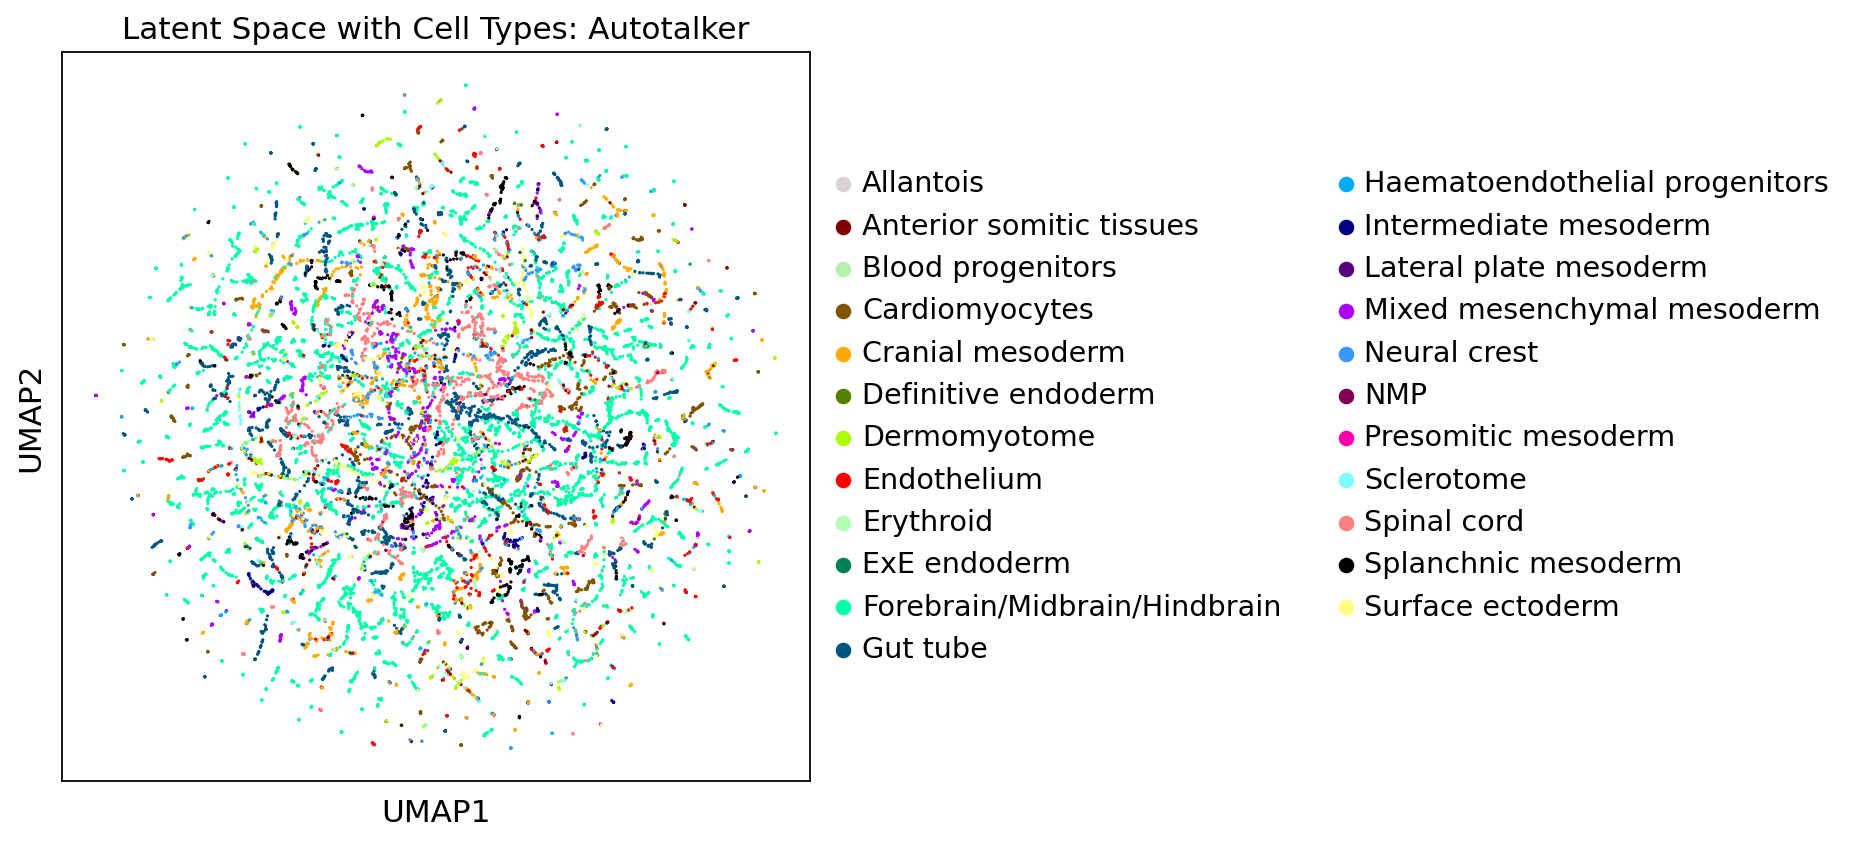

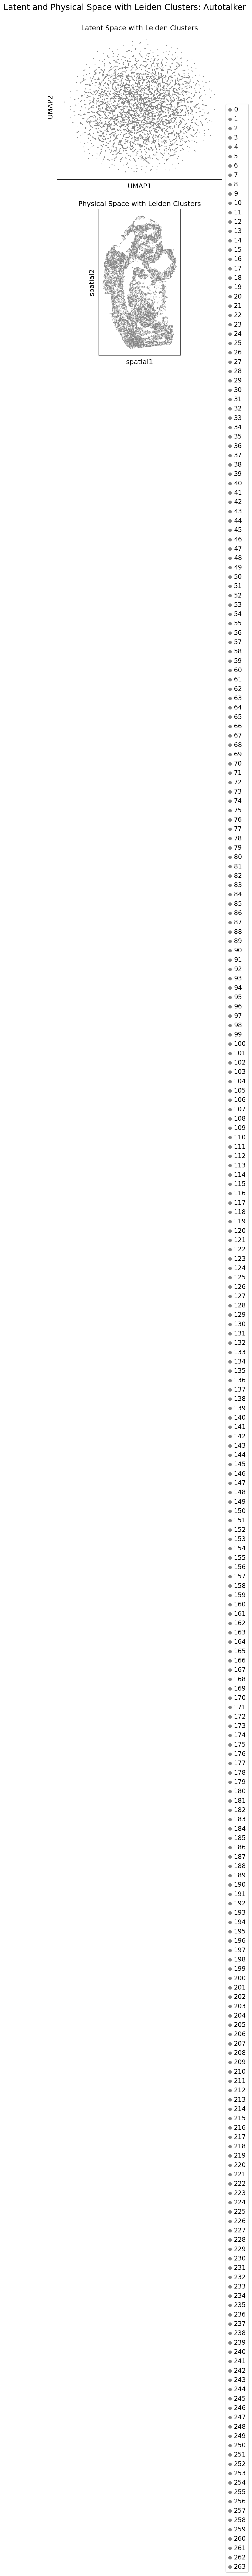

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
GRAPH ENCODER -> n_input: 351, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: -, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_addon_input: 0, n_output: 702
--- INITIALIZING TRAINER ---
Number of training nodes: 12767
Number of validation nodes: 1418
Number of training edges: 30388
Number of validation edges: 3376

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% train_global_loss: 585.4372; train_optim_loss: 585.4372; val_global_loss: 562.3155; val_optim_loss: 562.3155
Epoch 2/20 |██------------------| 10.0% train_global_loss: 549.2683; train_optim_loss: 549.2683; val_global_loss: 548.8744; val_optim_loss: 548.

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:393: UserWarning: Exited postprocessing with accuracies 
[2.01363467e-14 2.26757213e-06 1.86941462e-06 1.71641105e-06]
not reaching the requested tolerance 2.2351741790771484e-06.
  _, diffusion_map = lobpcg(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


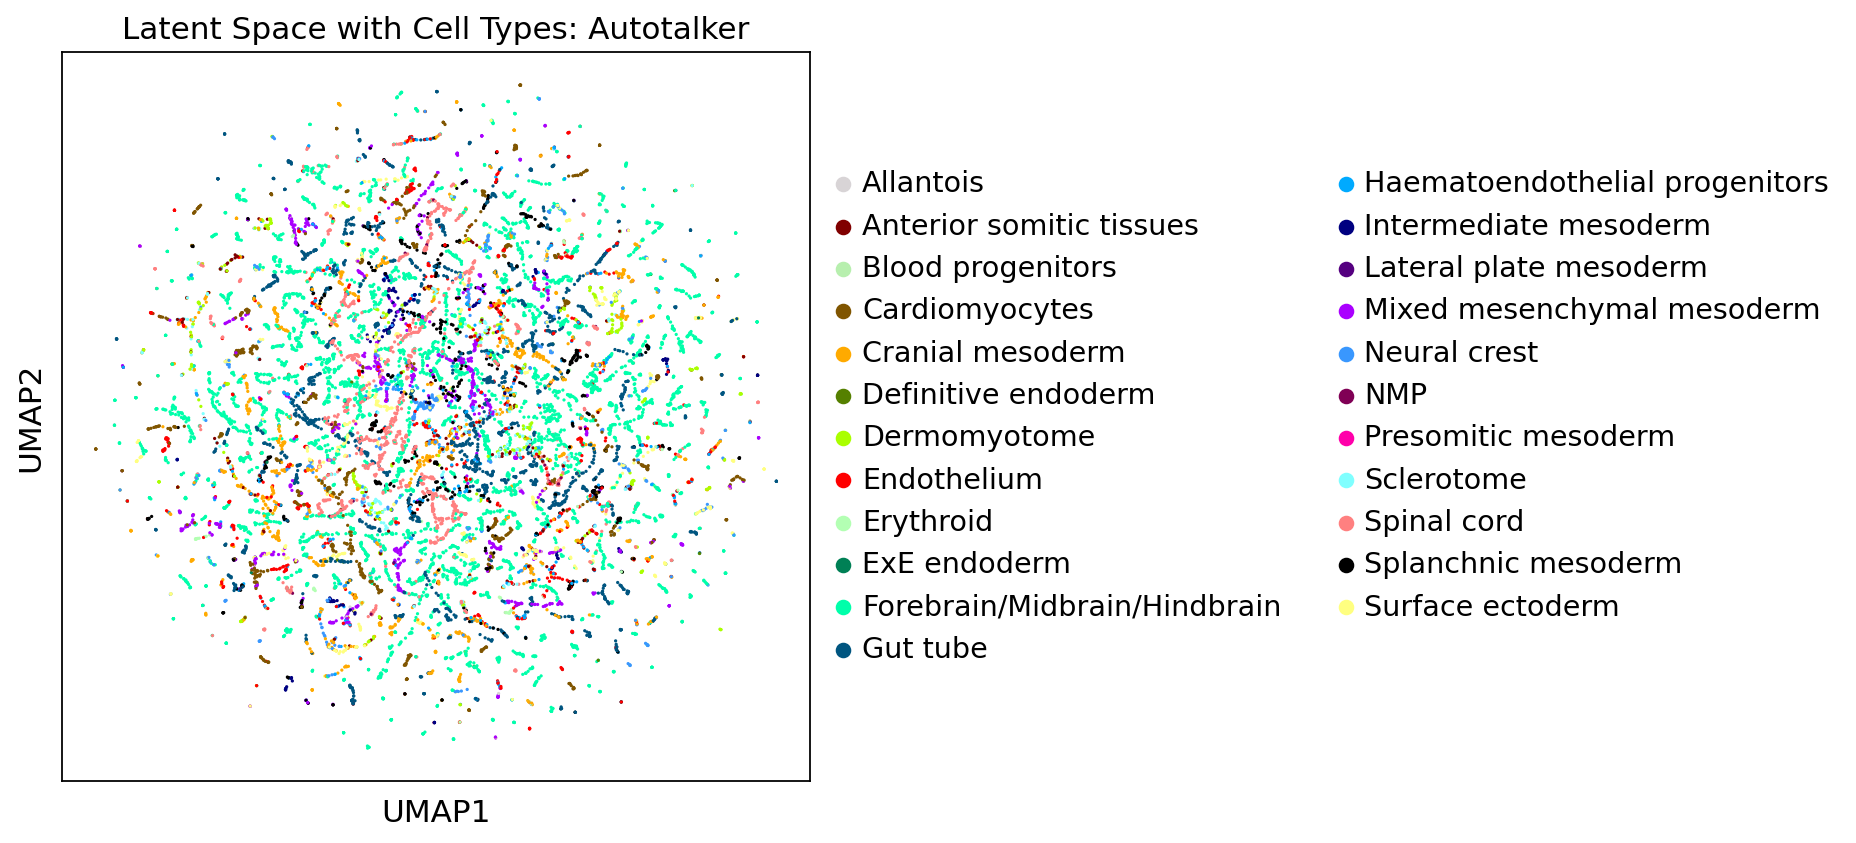

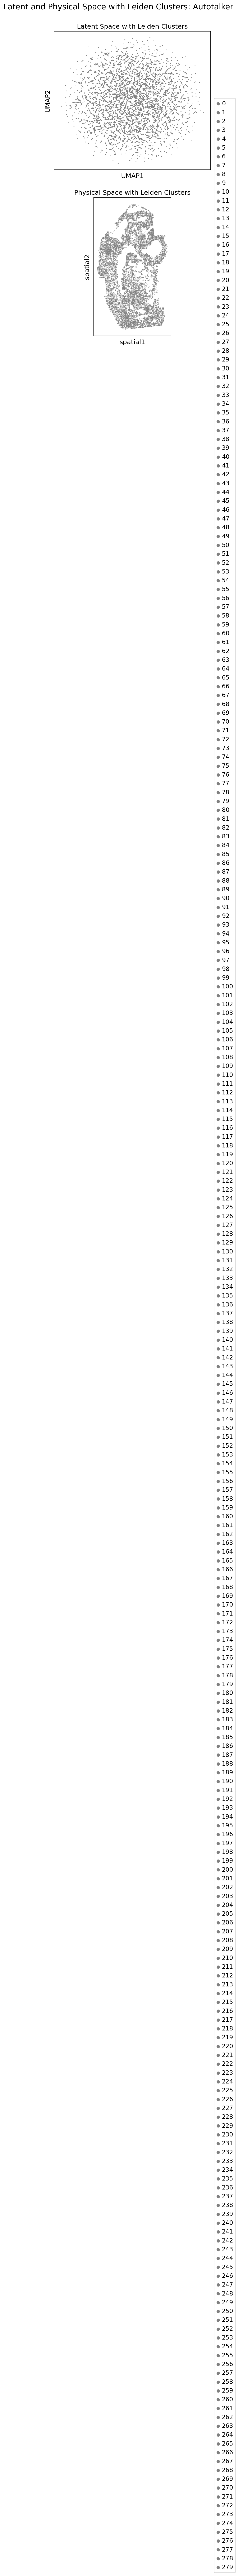

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
GRAPH ENCODER -> n_input: 351, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: -, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_addon_input: 0, n_output: 702
--- INITIALIZING TRAINER ---
Number of training nodes: 12767
Number of validation nodes: 1418
Number of training edges: 57592
Number of validation edges: 6399

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% train_global_loss: 536.3226; train_optim_loss: 536.3226; val_global_loss: 511.8642; val_optim_loss: 511.8642
Epoch 2/20 |██------------------| 10.0% train_global_loss: 507.4625; train_optim_loss: 507.4625; val_global_loss: 505.7843; val_optim_loss: 505.

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


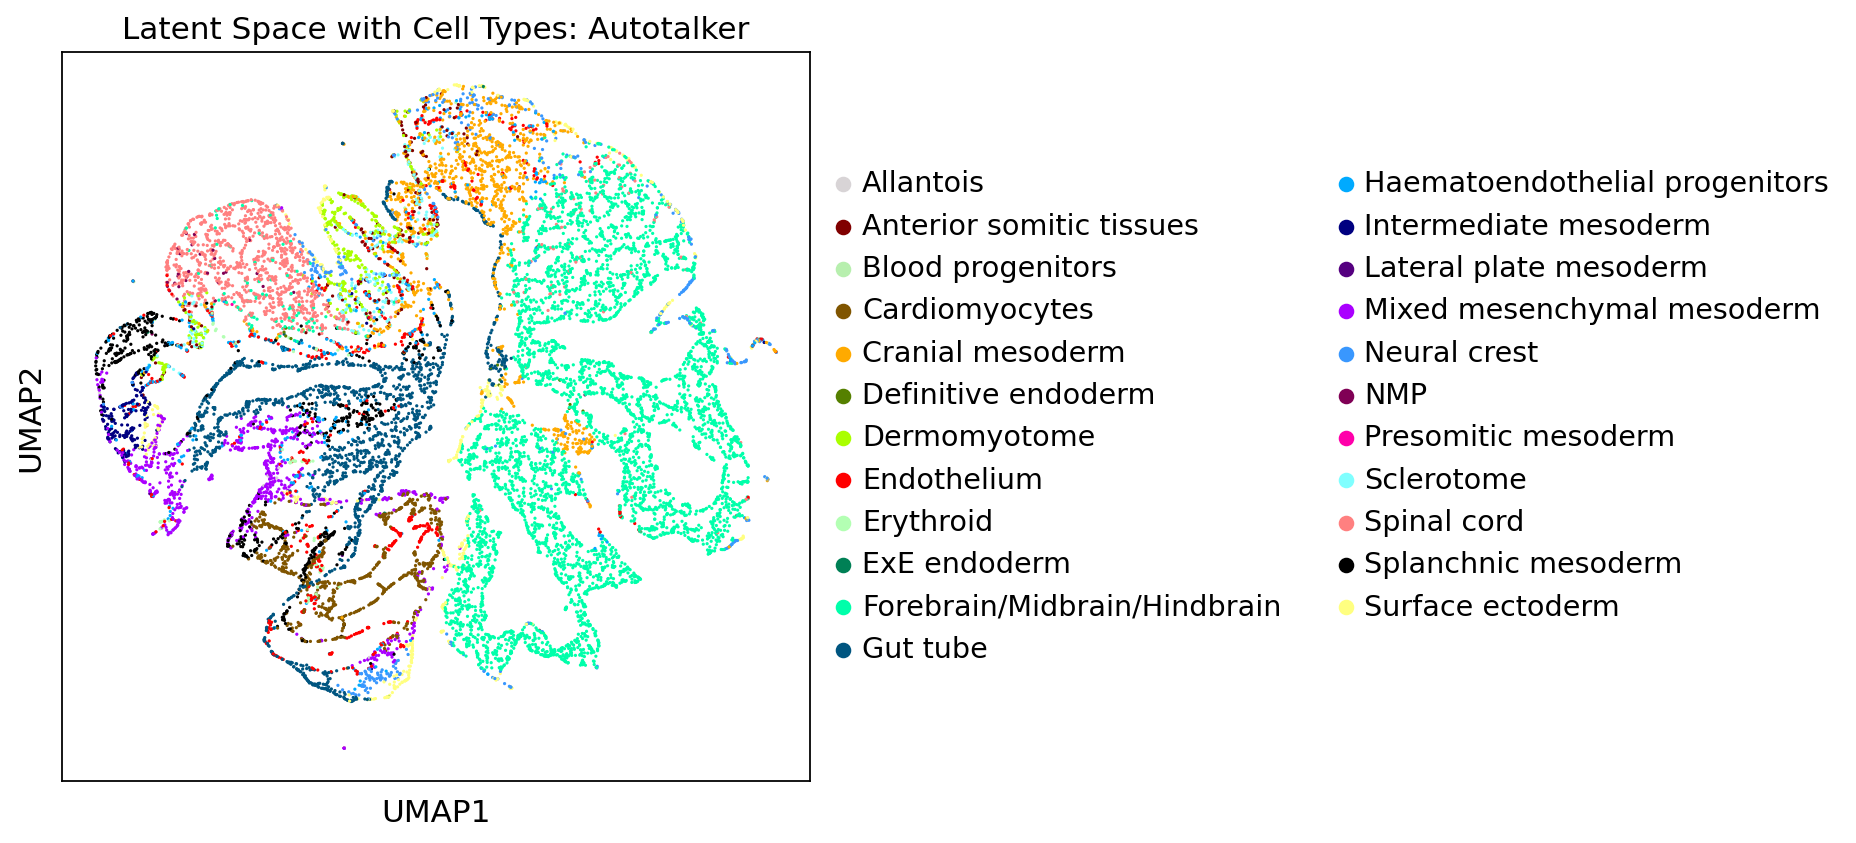

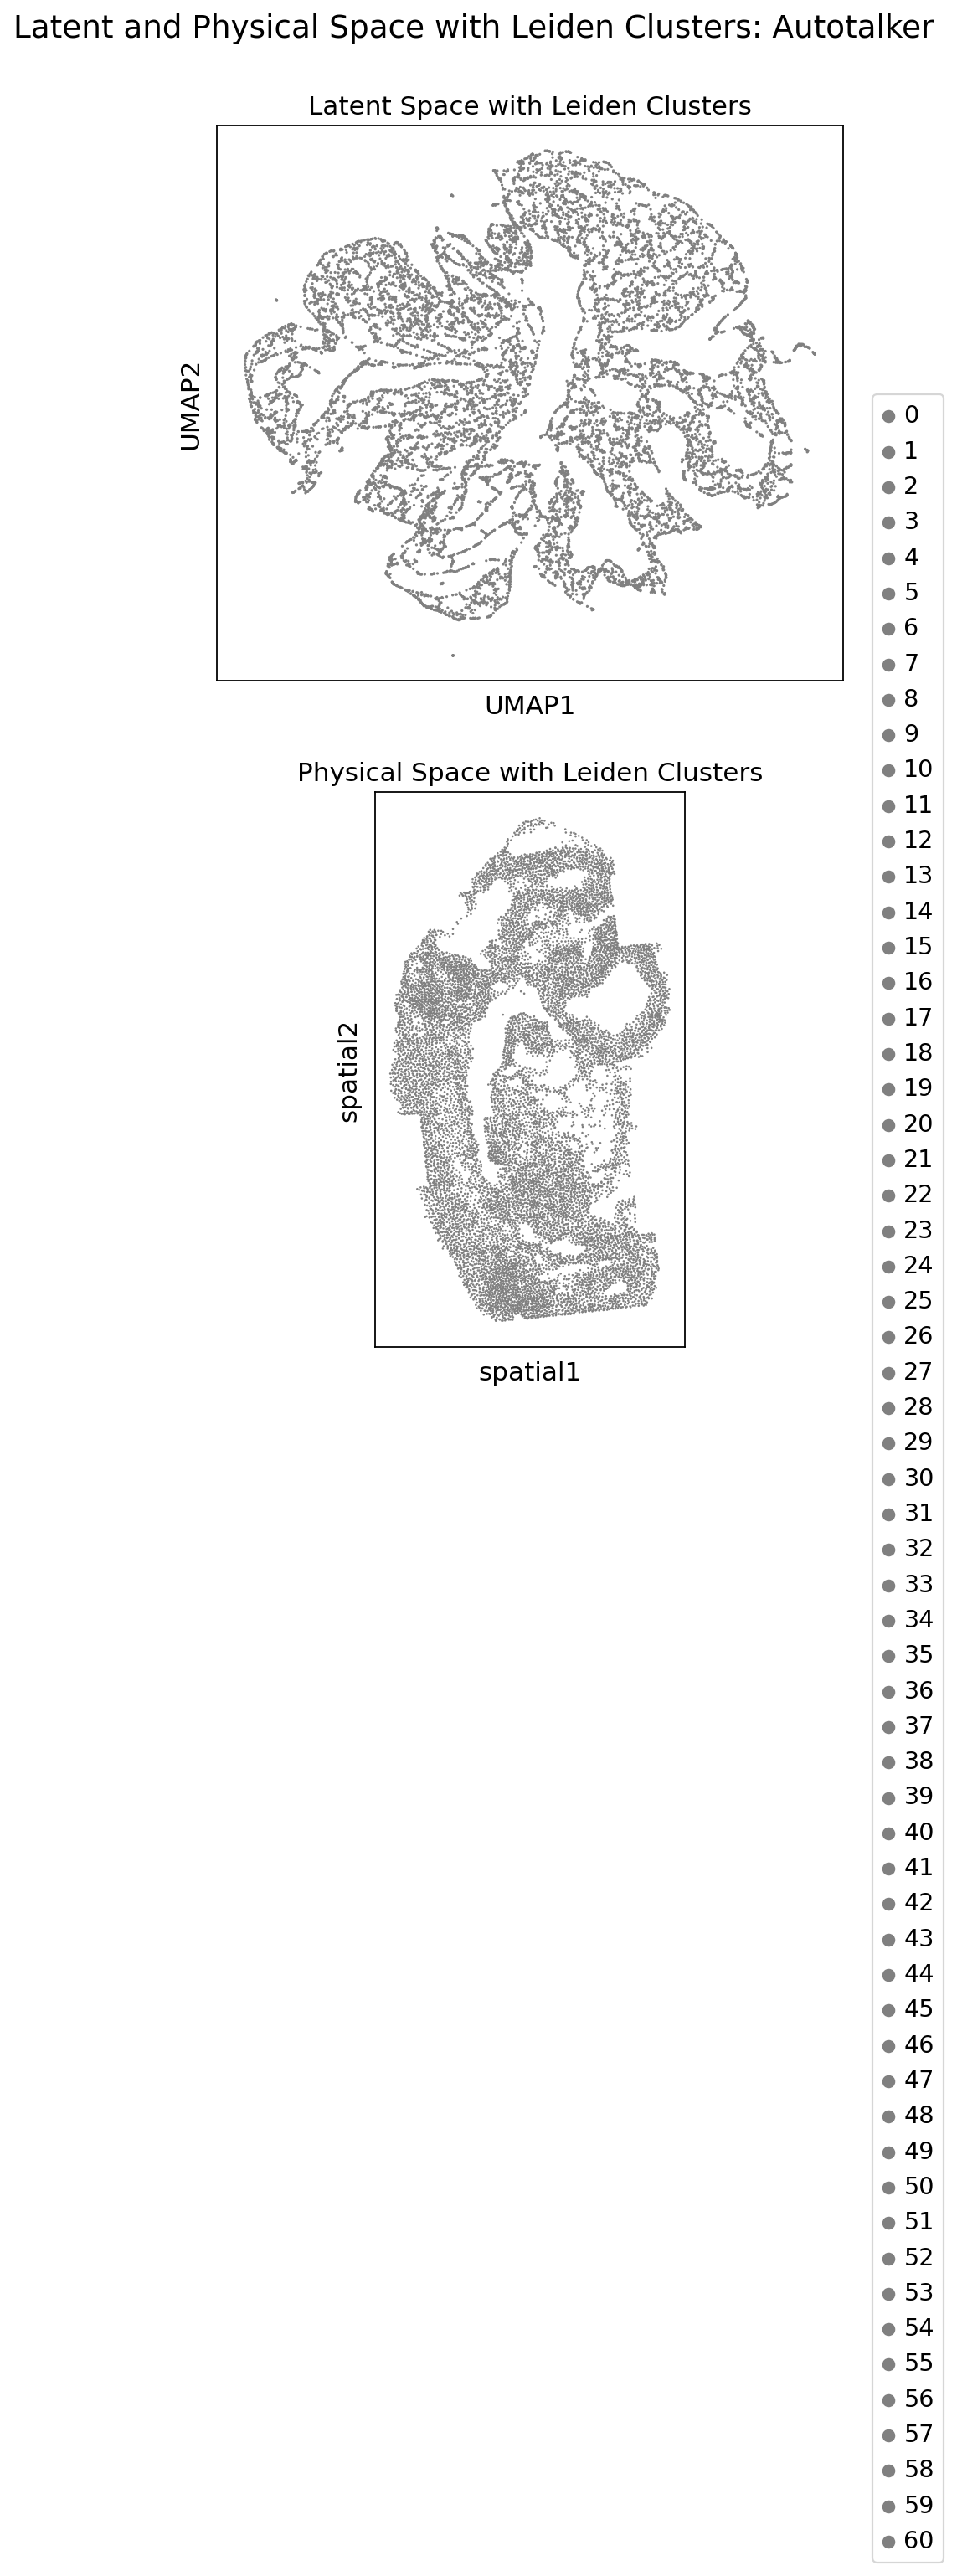

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
GRAPH ENCODER -> n_input: 351, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: -, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_addon_input: 0, n_output: 702
--- INITIALIZING TRAINER ---
Number of training nodes: 12767
Number of validation nodes: 1418
Number of training edges: 57592
Number of validation edges: 6399

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% train_global_loss: 537.3381; train_optim_loss: 537.3381; val_global_loss: 518.3993; val_optim_loss: 518.3993
Epoch 2/20 |██------------------| 10.0% train_global_loss: 507.5863; train_optim_loss: 507.5863; val_global_loss: 510.5323; val_optim_loss: 510.

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


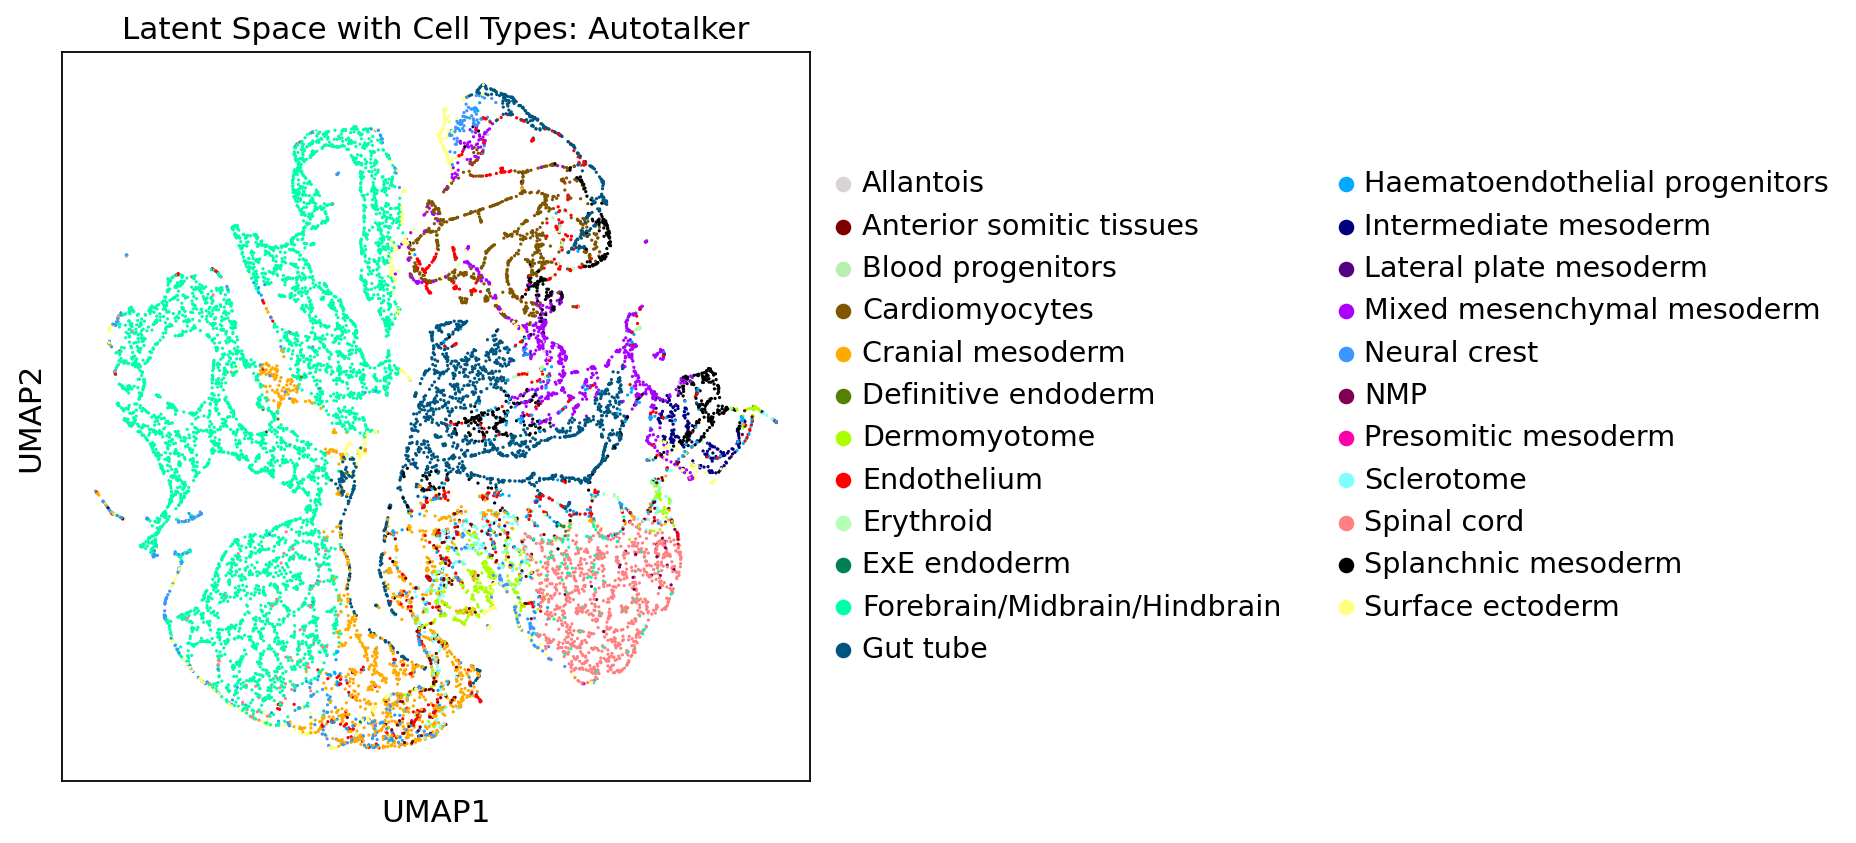

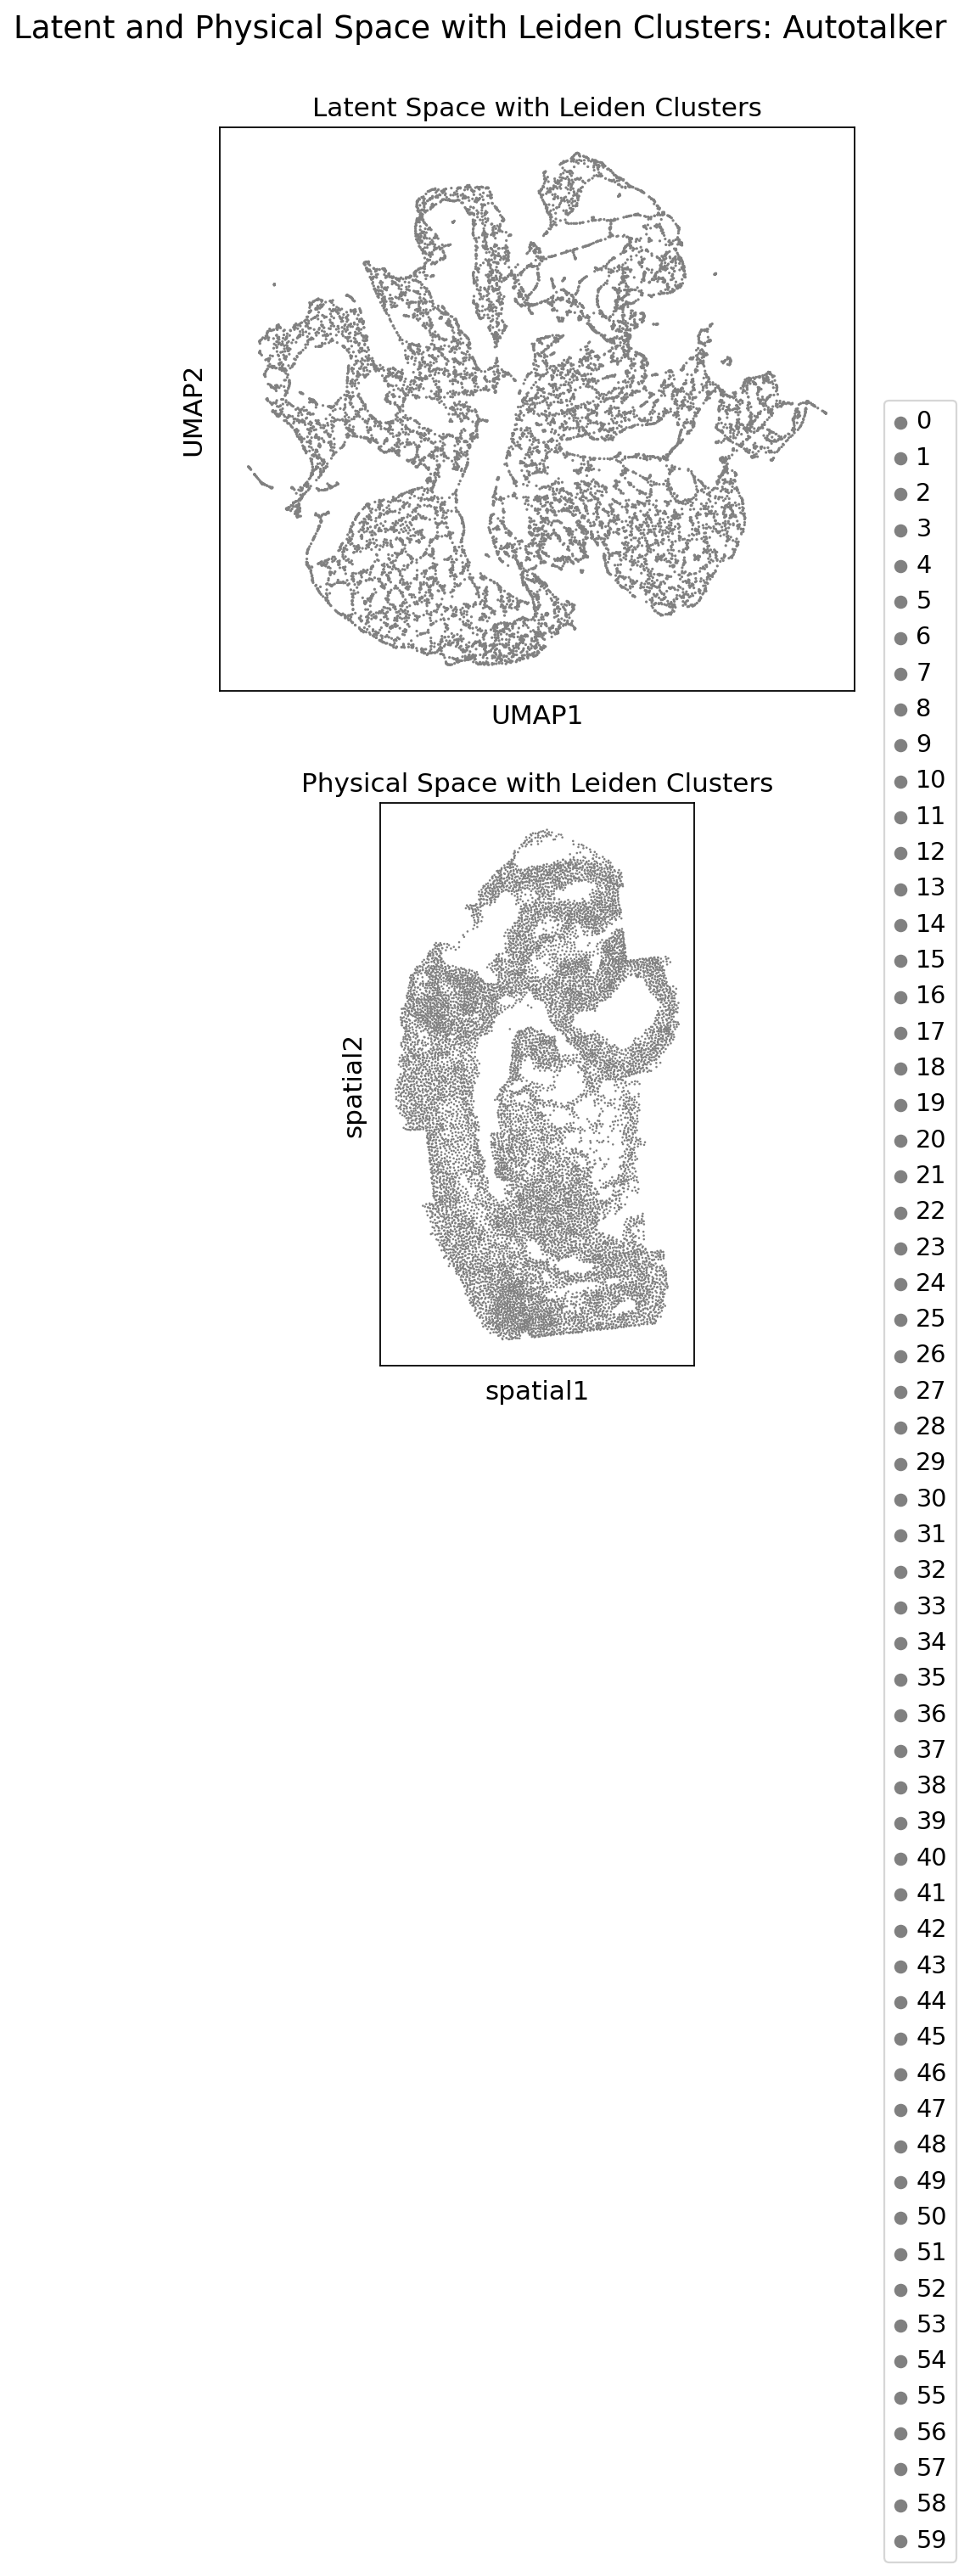

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
GRAPH ENCODER -> n_input: 351, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: -, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_addon_input: 0, n_output: 702
--- INITIALIZING TRAINER ---
Number of training nodes: 12767
Number of validation nodes: 1418
Number of training edges: 85191
Number of validation edges: 9465

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% train_global_loss: 509.4616; train_optim_loss: 509.4616; val_global_loss: 485.3472; val_optim_loss: 485.3472
Epoch 2/20 |██------------------| 10.0% train_global_loss: 483.2646; train_optim_loss: 483.2646; val_global_loss: 479.7288; val_optim_loss: 479.

/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cartalop/anaconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


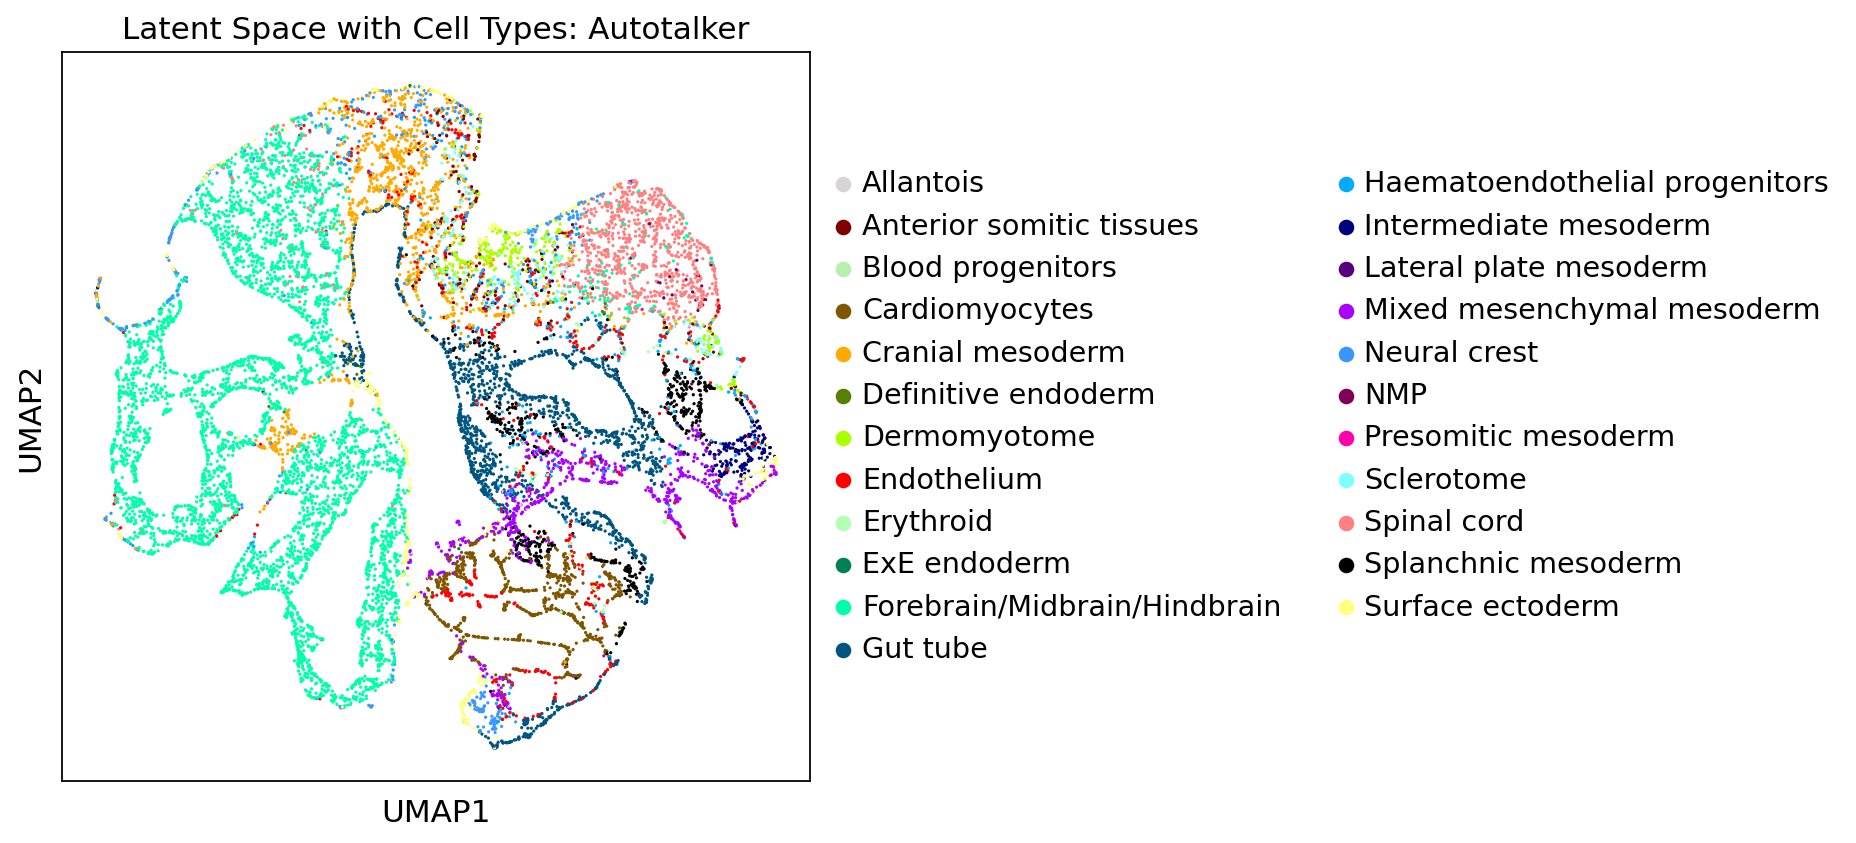

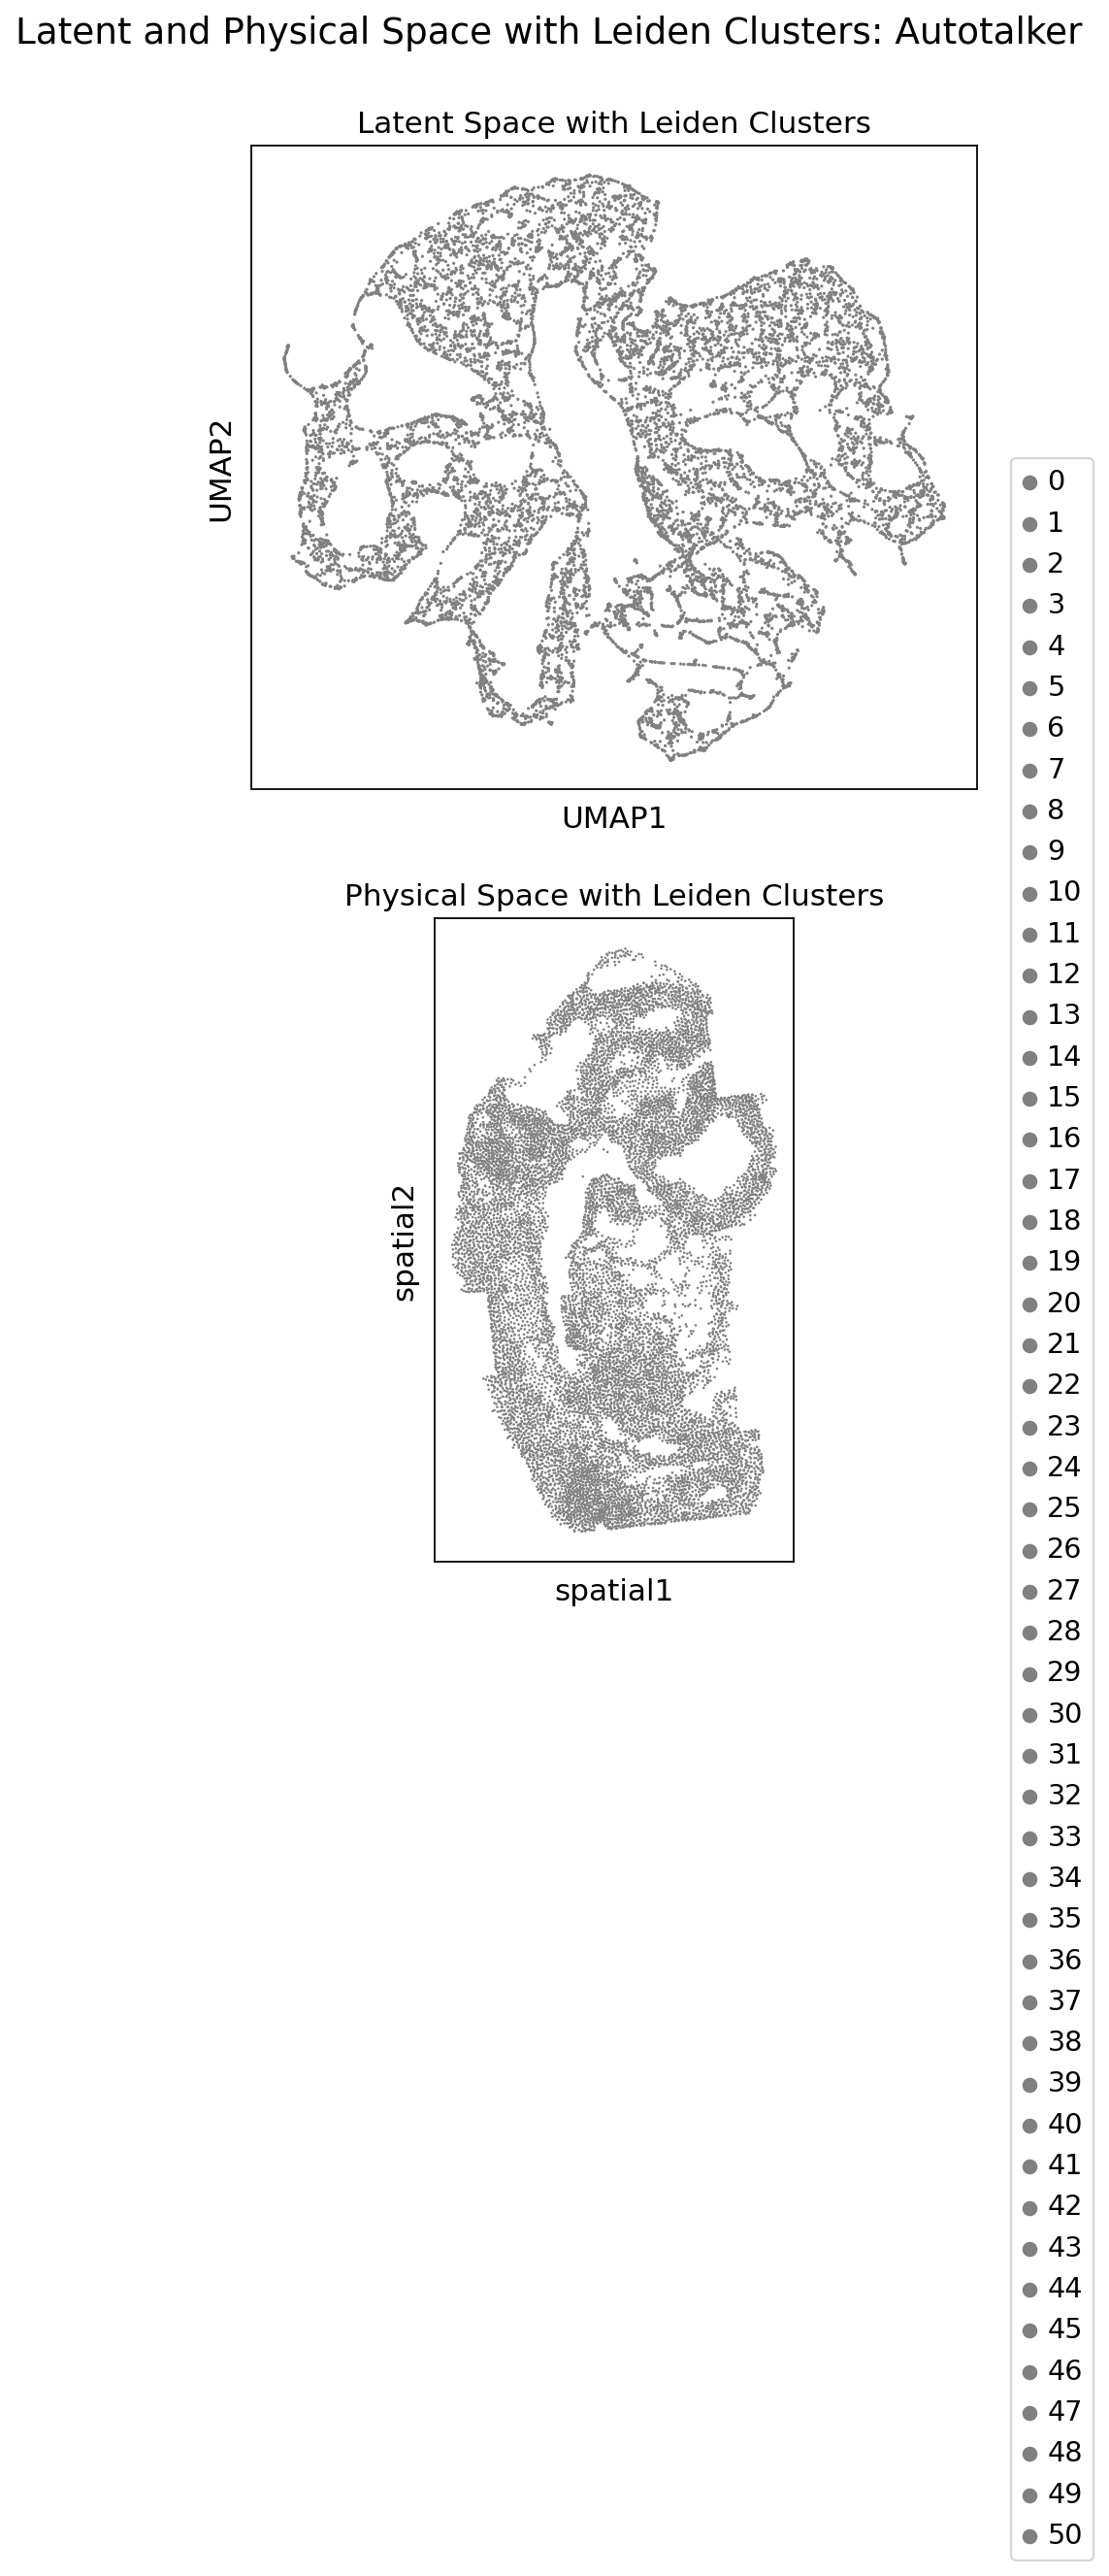

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb
NODE LABEL METHOD -> one-hop-attention
ACTIVE GP THRESHOLD RATIO -> 0.03
GRAPH ENCODER -> n_input: 351, n_hidden: 489, n_latent: 489, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: -, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 489, n_addon_input: 0, n_output: 702
--- INITIALIZING TRAINER ---
Number of training nodes: 12767
Number of validation nodes: 1418
Number of training edges: 85191
Number of validation edges: 9465

--- MODEL TRAINING ---
Epoch 1/20 |█-------------------| 5.0% train_global_loss: 506.5343; train_optim_loss: 506.5343; val_global_loss: 495.6148; val_optim_loss: 495.6148
Epoch 2/20 |██------------------| 10.0% train_global_loss: 482.0155; train_optim_loss: 482.0155; val_global_loss: 491.1638; val_optim_loss: 491.

In [ ]:
model_seeds = [0, 1] * 5 # different seeds for the 2 iterations for each 'n_neighbors'

for run_number, n_neighbors in enumerate([4, 4, 8, 8, 12, 12, 16, 16, 20, 20]):
    # Compute spatial neighborhood graph
    sq.gr.spatial_neighbors(adata,
                            coord_type="generic",
                            spatial_key="spatial",
                            n_neighs=n_neighbors)
    spatial_connectivities = adata.obsp["spatial_connectivities"].toarray()
    spatial_connectivities = spatial_connectivities + spatial_connectivities.T
    adata.obsp["spatial_connectivities"] = sp.csr_matrix(np.where(spatial_connectivities>1, 1, spatial_connectivities))
    
    # Initialize model
    model = Autotalker(adata,
                       counts_key="counts",
                       adj_key="spatial_connectivities",
                       gp_names_key="autotalker_gp_names",
                       active_gp_names_key="autotalker_active_gp_names",
                       gp_targets_mask_key="autotalker_gp_targets",
                       gp_sources_mask_key="autotalker_gp_sources",
                       latent_key=latent_key,
                       n_hidden_encoder=n_hidden_encoder)
    
    # Train model
    model.train(seed=model_seeds[run_number],
                edge_batch_size=16,
                node_batch_size=16)
    
    # Use expiMap latent space for UMAP generation
    sc.pp.neighbors(adata, use_rep=latent_key, n_neighbors=n_neighbors)
    sc.tl.umap(adata, min_dist=0.3)
    fig = sc.pl.umap(adata,
                     color=[cell_type_key],
                     title="Latent Space with Cell Types: Autotalker",
                     return_fig=True)
    fig.savefig(f"{figure_folder_path}/latent_autotalker_cell_types_run_{run_number + 1}_{current_timestamp}.png",
                bbox_inches="tight")
    
    # Compute latent Leiden clustering
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolution,
                 random_state=random_seed,
                 key_added=f"latent_autotalker_leiden_{str(leiden_resolution)}")
    
    # Create subplot of latent Leiden cluster annotations in physical and latent space
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
    title = fig.suptitle(t="Latent and Physical Space with Leiden Clusters: Autotalker")
    sc.pl.umap(adata=adata,
               color=[f"latent_autotalker_leiden_{str(leiden_resolution)}"],
               title=f"Latent Space with Leiden Clusters",
               ax=axs[0],
               show=False)
    sc.pl.spatial(adata=adata,
                  color=[f"latent_autotalker_leiden_{str(leiden_resolution)}"],
                  spot_size=0.03,
                  title=f"Physical Space with Leiden Clusters",
                  ax=axs[1],
                  show=False)

    # Create and position shared legend
    handles, labels = axs[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(1.1, 0.75))
    axs[0].get_legend().remove()
    axs[1].get_legend().remove()

    # Adjust, save and display plot
    plt.subplots_adjust(wspace=0, hspace=0.2)
    fig.savefig(f"{figure_folder_path}/latent_physical_comparison_autotalker_leiden_{run_number + 1}_{current_timestamp}.png",
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
    plt.show()
    
    # Store latent representation
    adata_original.obsm[latent_key + f"_run{run_number + 1}"] = adata.obsm[latent_key]

    # Store active gene programs
    adata_original.uns[f"autotalker_active_gp_names_run{run_number + 1}"] = adata.uns["autotalker_active_gp_names"]
    
    # Store intermediate adata to disk
    adata_original.write(f"{data_folder_path}/{dataset}_autotalker.h5ad")
    
# Add sample as observation
adata_original.obs["sample"] = "embryo2"
    
# Store final adata to disk
adata_original.write(f"{data_folder_path}/{dataset}_autotalker.h5ad")    